## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = r'C:\Users\lpott\Desktop\UCLA\ECENGR247C-80\HW2\cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.3277607028048712


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

When the weights are initialized random, we may assume that the model guesses randomly, and therefore class guesses are also random, so that $p(y_i | x_i)= 0.10$, and the -log(0.10) $\approx$ 2.3025.

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.017430 analytic: 0.017430, relative error: 1.323542e-06
numerical: 1.338108 analytic: 1.338108, relative error: 2.222345e-08
numerical: -0.425841 analytic: -0.425841, relative error: 1.316732e-08
numerical: 1.626517 analytic: 1.626517, relative error: 1.403175e-08
numerical: 0.579161 analytic: 0.579161, relative error: 6.079980e-08
numerical: 1.150142 analytic: 1.150142, relative error: 2.695416e-08
numerical: -0.367777 analytic: -0.367777, relative error: 1.351352e-07
numerical: -1.278940 analytic: -1.278940, relative error: 5.458980e-09
numerical: -0.410792 analytic: -0.410792, relative error: 7.169345e-11
numerical: -3.578951 analytic: -3.578951, relative error: 1.945720e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.329149895839901 / 325.46903479408985 computed in 0.04388260841369629s
Vectorized loss / grad: 2.3291498958399006 / 325.46903479408985 computed in 0.0019974708557128906s
difference in loss / grad: 4.440892098500626e-16 /2.3378258439630865e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

A major difference is that the softmax gradient descent will continue to update model weights even when the classifier correctly classifies a data point, but the SVM will no longer optimize the model weighted to try to do better than it already has, hence the gradient is zero once the SVM correctly classifies a data point.

Another difference between the gradient descent step in softmax function versus the svm training step is the subgradient from the max function in the hinge loss for SVM. The softmax gradient is differentiable, whereas the svm gradient is non-differentiable (due to the sharp point in the max function).

iteration 0 / 1500: loss 2.3365926606637544
iteration 100 / 1500: loss 2.0557222613850827
iteration 200 / 1500: loss 2.0357745120662813
iteration 300 / 1500: loss 1.9813348165609888
iteration 400 / 1500: loss 1.9583142443981612
iteration 500 / 1500: loss 1.8622653073541355
iteration 600 / 1500: loss 1.8532611454359387
iteration 700 / 1500: loss 1.8353062223725827
iteration 800 / 1500: loss 1.829389246882764
iteration 900 / 1500: loss 1.8992158530357484
iteration 1000 / 1500: loss 1.97835035402523
iteration 1100 / 1500: loss 1.8470797913532633
iteration 1200 / 1500: loss 1.8411450268664082
iteration 1300 / 1500: loss 1.7910402495792102
iteration 1400 / 1500: loss 1.8705803029382257
That took 3.527080774307251s


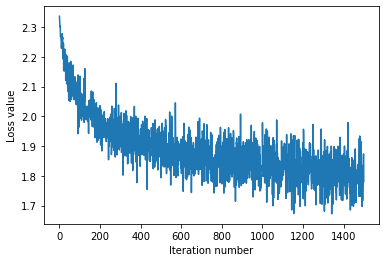

In [10]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [11]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [12]:
np.finfo(float).eps

2.220446049250313e-16

In [13]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the softmax that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
alphas = [1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]
best_loss = 2.4 ; best_val = 0; best_alpha=alphas[0];
train_accs = []
val_accs = []
for alpha in alphas:
    tic = time.time()
    _ = softmax.train(X_train, y_train, learning_rate=alpha,
                      num_iters=3000, batch_size=200,verbose=False)
    
    print("-"*50)
    print("Alpha={}\n".format(alpha))
    y_train_pred = softmax.predict(X_train)
    train_acc = np.mean(np.equal(y_train,y_train_pred), )
    print('training accuracy: {}'.format(train_acc))
    y_val_pred = softmax.predict(X_val)
    val_acc = np.mean(np.equal(y_val, y_val_pred))
    print('validation accuracy: {}'.format(val_acc))
    
    loss, _ = softmax.fast_loss_and_grad(X_val, y_val)
    print('validation loss: {}'.format(loss))
    
    if loss < best_loss:
        best_weight = np.copy(softmax.W)
        best_val = np.mean(np.equal(y_val, y_val_pred))
        best_loss = loss
        best_alpha = alpha
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    toc = time.time()
    
    print('That took {}s'.format(toc - tic))
   
print("-"*50)
print("-"*50)
print("The Learning Rate: {}\nThe best validation loss: {}\nThe best validation accuracy: {}\n".format(best_alpha,best_loss,best_val))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


--------------------------------------------------
Alpha=0.0001

training accuracy: 0.2963469387755102
validation accuracy: 0.276
validation loss: 30.646599542169135
That took 6.97187614440918s
--------------------------------------------------
Alpha=1e-05

training accuracy: 0.36826530612244895
validation accuracy: 0.336
validation loss: 2.602985493891085
That took 6.980832576751709s
--------------------------------------------------
Alpha=1e-06

training accuracy: 0.43385714285714283
validation accuracy: 0.407
validation loss: 1.7367674984829713
That took 6.964061498641968s
--------------------------------------------------
Alpha=1e-07

training accuracy: 0.3974285714285714
validation accuracy: 0.397
validation loss: 1.7874299973271968
That took 6.9519243240356445s
--------------------------------------------------
Alpha=1e-08

training accuracy: 0.3223673469387755
validation accuracy: 0.34
validation loss: 1.9466422442088902
That took 6.998324871063232s
-----------------------------

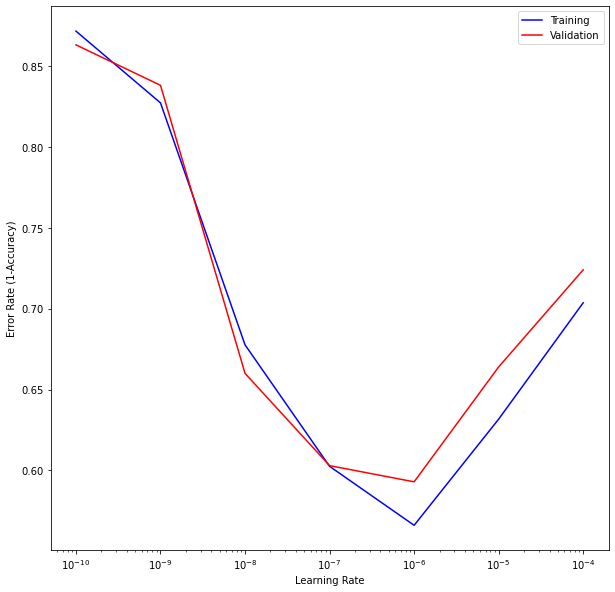

In [14]:
plt.figure(figsize=(10,10))
plt.plot(alphas,1-np.array(train_accs),'b-')
plt.plot(alphas,1-np.array(val_accs),'r-')
plt.xticks(alphas,alphas)
plt.semilogx()
plt.xlabel('Learning Rate')
plt.ylabel('Error Rate (1-Accuracy)')
plt.legend(['Training','Validation'])
plt.show()

In [15]:
softmax.W = best_weight
y_val_test = softmax.predict(X_test)
print('test accuracy: {}'.format(np.mean(np.equal(y_test, y_val_test)), ))

test accuracy: 0.396


## The best learning rate was 1e-6, with the corresponding best testing accuracy of .396, or error rate of 0.604

# softmax.py

In [16]:
def loss(self, X, y):
    """
    Calculates the softmax loss.
  
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
  
    Inputs:
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
  
    Returns a tuple of:
    - loss as single float
    """

    # Initialize the loss to zero.
    loss = 0.0

    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the normalized softmax loss.  Store it as the variable loss.
    #   (That is, calculate the sum of the losses of all the training 
    #   set margins, and then normalize the loss by the number of 
	#	training examples.)
    # ================================================================ #
    N = X.shape[0]
    for i in range(N):
        score_i = np.matmul(self.W,X[i,:].T)
        normalized_scores_i = np.exp(score_i)/(np.sum(np.exp(score_i)))
                                              
        loss -= 1/N*np.log(normalized_scores_i[y[i]]+np.finfo(float).eps)
                              
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss

In [17]:
  def loss_and_grad(self, X, y):
    """
	Same as self.loss(X, y), except that it also returns the gradient.

	Output: grad -- a matrix of the same dimensions as W containing 
		the gradient of the loss with respect to W.
	"""

    # Initialize the loss and gradient to zero.
    loss = 0.0
    grad = np.zeros_like(self.W)
  
    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the softmax loss and the gradient. Store the gradient
	#   as the variable grad.
    # ================================================================ #

    N = X.shape[0]
    
    for i in np.arange(N):
        score_i = np.matmul(self.W,X[i,:].T)
        normalized_scores_i = np.exp(score_i)/(np.sum(np.exp(score_i)))
        loss -= 1/N*np.log(normalized_scores_i[y[i]])
        
        dydz_i = normalized_scores_i
        dydz_i[y[i]] = dydz_i[y[i]] - 1
        
        grad += 1/N*np.matmul(dydz_i[:,np.newaxis],X[i,:][np.newaxis,:])
        
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

In [18]:
def fast_loss_and_grad(self, X, y):
    """
    A vectorized implementation of loss_and_grad. It shares the same
	inputs and ouptuts as loss_and_grad.
    """
    loss = 0.0
    grad = np.zeros(self.W.shape) # initialize the gradient as zero
    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the softmax loss and gradient WITHOUT any for loops.
    # ================================================================ #
    scores = np.dot(self.W,X.T)
    normalized_scores = np.exp(scores)/(np.sum(np.exp(scores),axis=0)[np.newaxis,:])
    loss = -np.mean(np.log(normalized_scores.T[np.arange(X.shape[0]),y]))
    
    
    dydz = normalized_scores
    dydz[y,np.arange(X.shape[0])] = dydz[y,np.arange(X.shape[0])] - 1        


    grad = 1/X.shape[0] * (np.matmul(dydz,X))
    
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

In [19]:
def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

    self.init_weights(dims=[np.max(y) + 1, X.shape[1]])	# initializes the weights of self.W

    # Run stochastic gradient descent to optimize W
    loss_history = []

    for it in np.arange(num_iters):
      idx_batch = np.random.choice(num_train,batch_size)
      X_batch = X[idx_batch,:]
      y_batch = y[idx_batch]
      # ================================================================ #
      # YOUR CODE HERE:
      #   Sample batch_size elements from the training data for use in 
      #	  gradient descent.  After sampling,
      #     - X_batch should have shape: (dim, batch_size)
	  #     - y_batch should have shape: (batch_size,)
	  #   The indices should be randomly generated to reduce correlations
	  #   in the dataset.  Use np.random.choice.  It's okay to sample with
	  #   replacement.
      # ================================================================ #
      pass
      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      # evaluate loss and gradient
      loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
      loss_history.append(loss)

      # ================================================================ #
      # YOUR CODE HERE:
      #   Update the parameters, self.W, with a gradient step 
      # ================================================================ #
      self.W = self.W - learning_rate * grad
      pass

	  # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      if verbose and it % 100 == 0:
        print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

    return loss_history

In [20]:
def predict(self, X):
    """
    Inputs:
    - X: N x D array of training data. Each row is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    # ================================================================ #
    # YOUR CODE HERE:
    #   Predict the labels given the training data.
    # ================================================================ #
    scores = np.dot(self.W,X.T)
    normalized_scores = np.exp(scores)/(np.sum(np.exp(scores),axis=0)[np.newaxis,:])
    y_pred = np.argmax(normalized_scores,axis=0)
    pass
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return y_pred